
# Metrics

## Data

### Close value

In [1]:
import sys

sys.path.append('..')
from timeseries.timeseries import StockMarketSeries
from timeseries.utils import SeriesColumn, DeviationSource, DeviationScale
from metrics.utils import MetricLevel, print_relation_results

company_name = "Adobe"
path = "../data/timeseries/adobe.csv"
time_series_start = 0
time_series_end = 300
stock = StockMarketSeries(company_name, path, time_series_start, time_series_end,
                          all_noises_strength={DeviationScale.SLIGHTLY: 0.7,
                                               DeviationScale.MODERATELY: 3.0,
                                               DeviationScale.HIGHLY: 7.0},
                          all_incomplete_parts={DeviationScale.SLIGHTLY: 0.05,
                                                DeviationScale.MODERATELY: 0.12,
                                                DeviationScale.HIGHLY: 0.3},
                          partially_noised_strength={SeriesColumn.CLOSE: {DeviationScale.SLIGHTLY: 0.6,
                                                                          DeviationScale.MODERATELY: 2.0,
                                                                          DeviationScale.HIGHLY: 6.0},
                                                     SeriesColumn.OPEN: {DeviationScale.SLIGHTLY: 0.4,
                                                                         DeviationScale.MODERATELY: 1.7,
                                                                         DeviationScale.HIGHLY: 5.2}},
                          partially_incomplete_parts={SeriesColumn.CLOSE: {DeviationScale.SLIGHTLY: 0.05,
                                                                           DeviationScale.MODERATELY: 0.12,
                                                                           DeviationScale.HIGHLY: 0.3},
                                                      SeriesColumn.OPEN: {DeviationScale.SLIGHTLY: 0.05,
                                                                          DeviationScale.MODERATELY: 0.12,
                                                                          DeviationScale.HIGHLY: 0.3}})

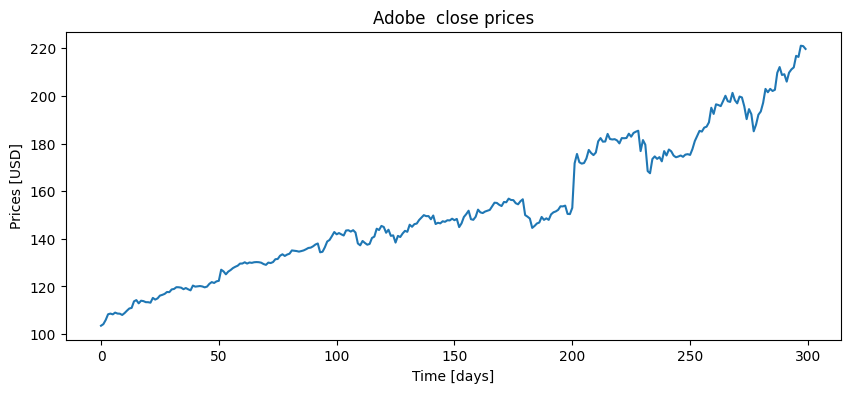

In [2]:
stock.plot_single_series(stock.real_series[SeriesColumn.CLOSE], SeriesColumn.CLOSE)

### Other values

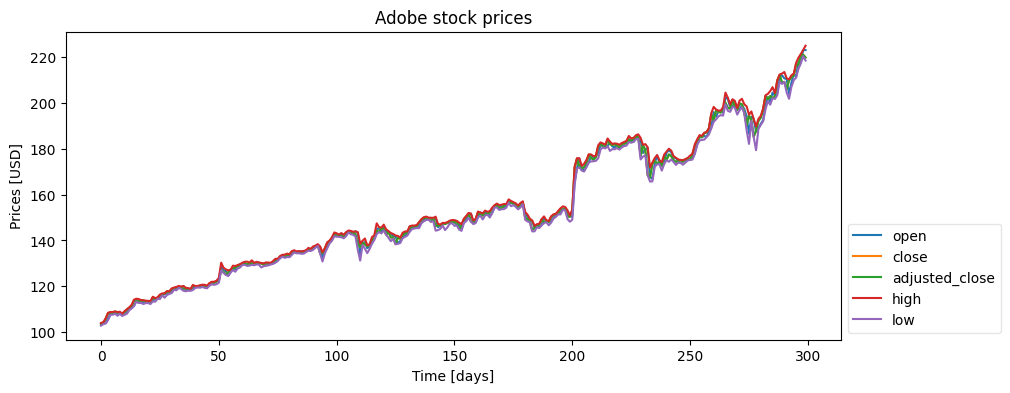

In [3]:
stock.plot_multiple_series("stock prices",
                           open=stock.real_series[SeriesColumn.OPEN],
                           close=stock.real_series[SeriesColumn.CLOSE],
                           adjusted_close=stock.real_series[SeriesColumn.ADJ_CLOSE],
                           high=stock.real_series[SeriesColumn.HIGH],
                           low=stock.real_series[SeriesColumn.LOW])

## Correctness metric

### Show noise

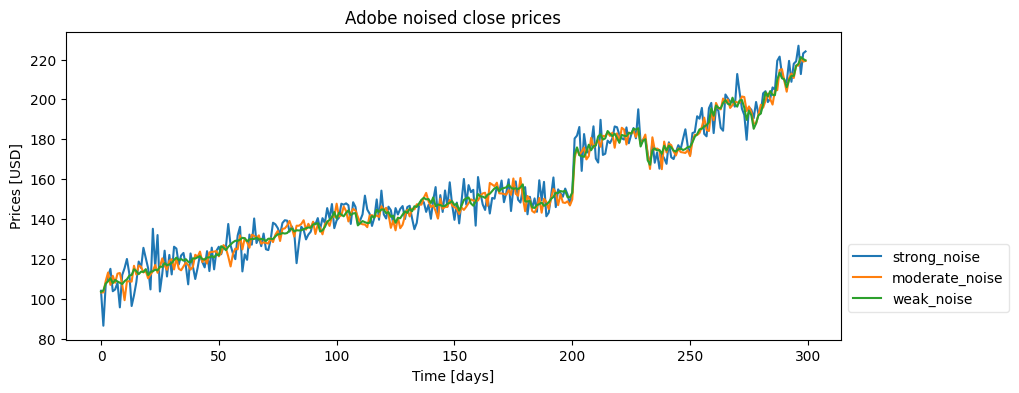

In [4]:
stock.plot_multiple_series("noised close prices",
                           strong_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.HIGHLY][
                               SeriesColumn.CLOSE],
                           moderate_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.MODERATELY][
                               SeriesColumn.CLOSE],
                           weak_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.SLIGHTLY][
                               SeriesColumn.CLOSE])

### Heinrich's correctness metric on values

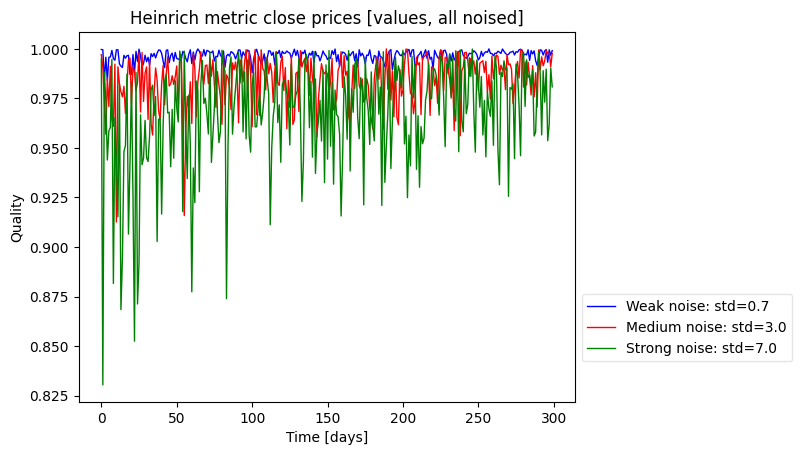

In [5]:
from correctness import HeinrichCorrectnessMetric
from timeseries.utils import DeviationRange

heinrich = HeinrichCorrectnessMetric(stock,
                                     alpha={SeriesColumn.OPEN: 1.6,
                                            SeriesColumn.CLOSE: 2.1,
                                            SeriesColumn.ADJ_CLOSE: 1.7,
                                            SeriesColumn.HIGH: 2.0,
                                            SeriesColumn.LOW: 2.3,
                                            SeriesColumn.VOLUME: 3.1})

qualities = heinrich.values_qualities(SeriesColumn.CLOSE, is_alpha=False)
heinrich.draw_heinrich_qualities(qualities, MetricLevel.VALUES, is_alpha=False,
                                 column_name=SeriesColumn.CLOSE)

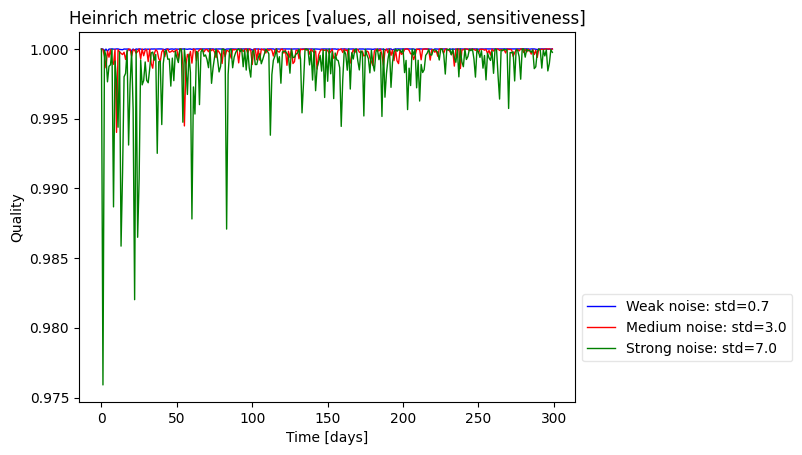

In [6]:
qualities = heinrich.values_qualities(SeriesColumn.CLOSE, is_alpha=True)
heinrich.draw_heinrich_qualities(qualities, MetricLevel.VALUES, is_alpha=True,
                                 column_name=SeriesColumn.CLOSE)

### Heinrich's correctness metric on tuples - all fields noised

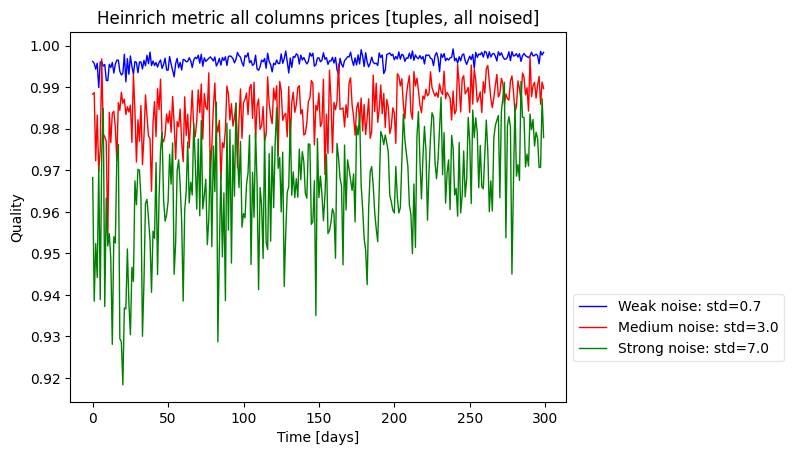

In [7]:
adobe_tuple_weights = [0.2, 0.2, 0.25, 0.15, 0.15, 0.05]

qualities = heinrich.tuples_qualities(adobe_tuple_weights, DeviationRange.ALL, is_alpha=False)
heinrich.draw_heinrich_qualities(qualities, MetricLevel.TUPLES, is_alpha=False, noise_range=DeviationRange.ALL)

### Heinrich's correctness metric on tuples - some fields noised

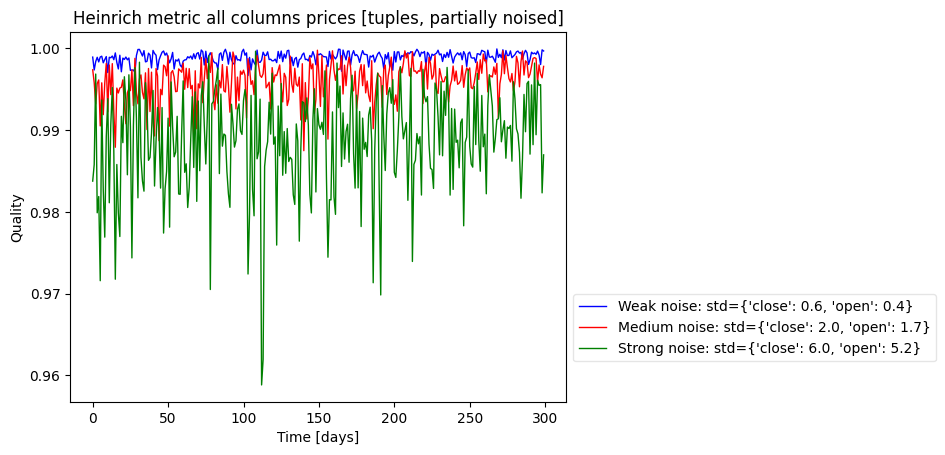

In [8]:
qualities = heinrich.tuples_qualities(adobe_tuple_weights, DeviationRange.PARTIAL, is_alpha=False)
heinrich.draw_heinrich_qualities(qualities, MetricLevel.TUPLES, is_alpha=False, noise_range=DeviationRange.PARTIAL)

### Heinrich's correctness metric on relation

In [9]:
qualities = heinrich.relation_qualities(adobe_tuple_weights, is_alpha=False)

print_relation_results(qualities, DeviationSource.NOISE, DeviationRange.ALL)

Relation quality differences due to different noise levels of all fields:
Data slightly deviated: 0.9964947010089042
Data moderately deviated: 0.9849979681868735
Data highly deviated: 0.9656930400339769


In [10]:
qualities = heinrich.relation_qualities(adobe_tuple_weights, DeviationRange.PARTIAL, is_alpha=False)

print_relation_results(qualities, DeviationSource.NOISE, DeviationRange.PARTIAL)

Relation quality differences due to different noise levels of some fields:
Data slightly deviated: 0.9989309193029654
Data moderately deviated: 0.9960557637832806
Data highly deviated: 0.9886117047253665


## Completeness metrics

### Show incompleteness

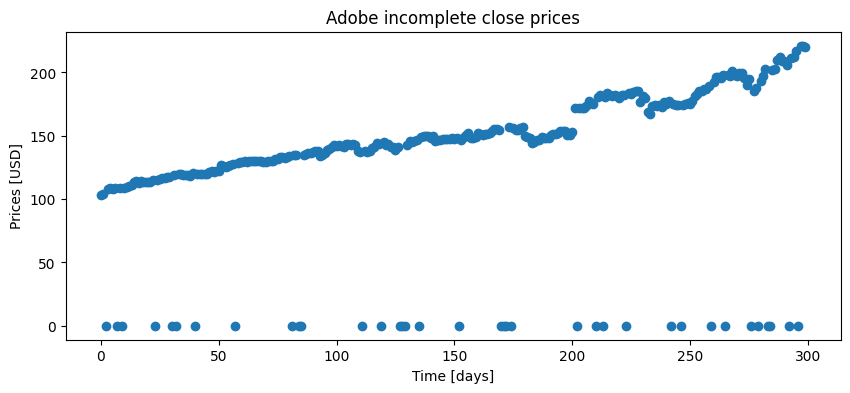

In [11]:
adobe_close_incomplete = stock.all_deviated_series[DeviationSource.INCOMPLETENESS][DeviationScale.MODERATELY][
    SeriesColumn.CLOSE]
stock.plot_single_series(adobe_close_incomplete, SeriesColumn.CLOSE, deviation="incomplete", plot_type="o")

### Blake's completeness metric on values

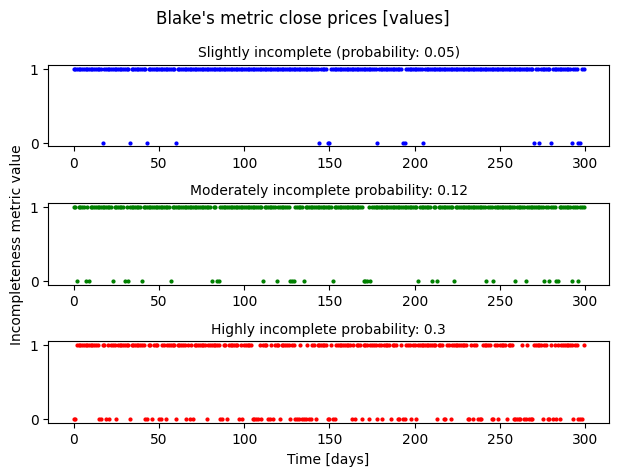

In [12]:
from metrics.completeness import BlakeCompletenessMetric

blake = BlakeCompletenessMetric(stock)
qualities = blake.values_qualities(SeriesColumn.CLOSE)
blake.draw_blake(qualities, MetricLevel.VALUES, column_name=SeriesColumn.CLOSE)

### Blake's completeness metric on tuples - all columns affected

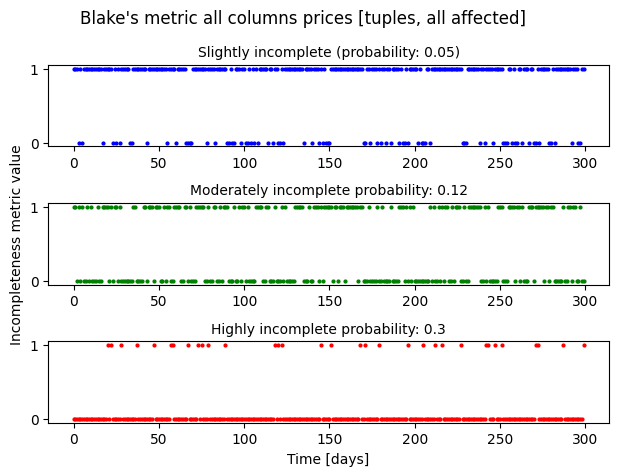

In [13]:
qualities = blake.tuples_qualities(incompleteness_range=DeviationRange.ALL)
blake.draw_blake(qualities, MetricLevel.TUPLES, incompleteness_range=DeviationRange.ALL)

### Blake's completeness metric on tuples - some columns affected

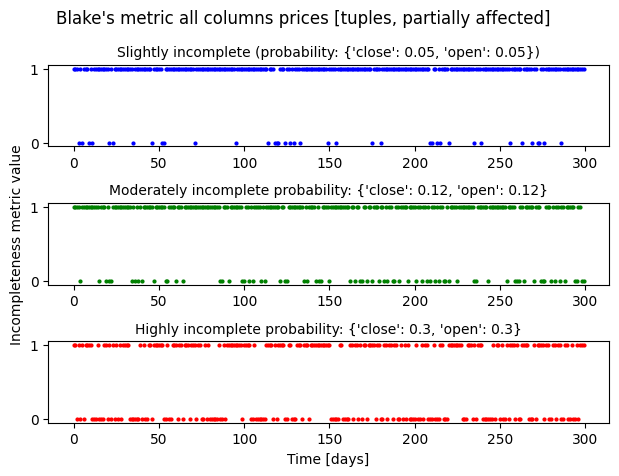

In [14]:
qualities = blake.tuples_qualities(incompleteness_range=DeviationRange.PARTIAL)
blake.draw_blake(qualities, MetricLevel.TUPLES, incompleteness_range=DeviationRange.PARTIAL)

### Blake's completeness metric on relation

In [15]:
qualities = blake.relation_qualities(incompleteness_range=DeviationRange.ALL)

print_relation_results(qualities, DeviationSource.INCOMPLETENESS, DeviationRange.ALL)

Relation quality differences due to different incompleteness levels of all fields:
Data slightly deviated: 0.74
Data moderately deviated: 0.4933333333333333
Data highly deviated: 0.10999999999999999


In [16]:
qualities = blake.relation_qualities(incompleteness_range=DeviationRange.PARTIAL)

print_relation_results(qualities, DeviationSource.INCOMPLETENESS, DeviationRange.PARTIAL)

Relation quality differences due to different incompleteness levels of some fields:
Data slightly deviated: 0.8733333333333333
Data moderately deviated: 0.75
Data highly deviated: 0.5566666666666666


## Timeliness metric

### Timeliness metric on values

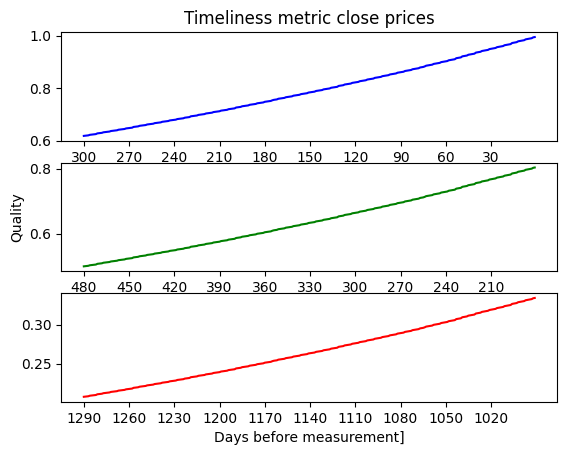

In [17]:
from metrics.timeliness import HeinrichTimelinessMetric

declines = {SeriesColumn.OPEN: 0.4,
            SeriesColumn.CLOSE: 0.4,
            SeriesColumn.ADJ_CLOSE: 0.3,
            SeriesColumn.HIGH: 0.4,
            SeriesColumn.LOW: 0.4,
            SeriesColumn.VOLUME: 0.7}

measurement_times = {DeviationScale.SLIGHTLY: 5,
                     DeviationScale.MODERATELY: 200,
                     DeviationScale.HIGHLY: 1000}

timeliness = HeinrichTimelinessMetric(stock)
time_deltas, qualities = timeliness.values_qualities(declines[SeriesColumn.CLOSE], measurement_times)
timeliness.draw_timeliness_qualities(time_deltas, qualities, SeriesColumn.CLOSE)

### Timeliness metric on tuples

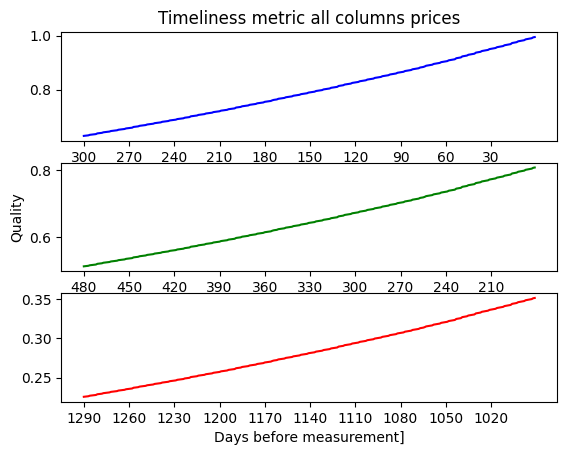

In [18]:
weights = {SeriesColumn.OPEN: 0.2,
           SeriesColumn.CLOSE: 0.2,
           SeriesColumn.ADJ_CLOSE: 0.25,
           SeriesColumn.HIGH: 0.15,
           SeriesColumn.LOW: 0.15,
           SeriesColumn.VOLUME: 0.05}

time_deltas, qualities = timeliness.tuples_qualities(declines, measurement_times, weights)
timeliness.draw_timeliness_qualities(time_deltas, qualities)

### Timeliness metric on relation

In [19]:
qualities = timeliness.relation_qualities(declines, measurement_times, weights)
print_relation_results(qualities, DeviationSource.TIMELINESS, DeviationRange.ALL)

Relation quality differences due to different obsolescence levels of all fields:
Data slightly deviated: 0.7961923796110164
Data moderately deviated: 0.6482589483012084
Data highly deviated: 0.2833211335660943
